In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [2]:
import os

path = "/kaggle/input/chest-xray-pneumonia"

# List files in the dataset folder
os.listdir(path)

['chest_xray']

In [3]:
!cp -r /kaggle/input/chest-xray-pneumonia /content/kaggle_PNEUMONIA

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import hashlib
import random
from PIL import Image
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.models import load_model
from huggingface_hub import login
from dotenv import load_dotenv
from huggingface_hub import HfApi
from huggingface_hub import hf_hub_download
import warnings
warnings.filterwarnings("ignore")

In [5]:
base_dir = "/content/kaggle_PNEUMONIA/chest_xray/chest_xray"
splits = ["train", "val", "test"]

unexpected_files = []

for split in splits:
    split_dir = os.path.join(base_dir, split)
    for root, _, files in os.walk(split_dir):
        for f in files:
            if not f.lower().endswith(".jpeg"):
                unexpected_files.append(os.path.join(root, f))

if unexpected_files:
    print("⚠️ Found unexpected files:")
    for uf in unexpected_files:
        print(uf)
else:
    print("✅ All files are .jpeg")

⚠️ Found unexpected files:
/content/kaggle_PNEUMONIA/chest_xray/chest_xray/train/.DS_Store
/content/kaggle_PNEUMONIA/chest_xray/chest_xray/train/NORMAL/.DS_Store
/content/kaggle_PNEUMONIA/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store
/content/kaggle_PNEUMONIA/chest_xray/chest_xray/val/.DS_Store
/content/kaggle_PNEUMONIA/chest_xray/chest_xray/val/NORMAL/.DS_Store
/content/kaggle_PNEUMONIA/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/content/kaggle_PNEUMONIA/chest_xray/chest_xray/test/.DS_Store


In [6]:
train_dir = "/content/kaggle_PNEUMONIA/chest_xray/chest_xray/train"

def is_image_file(filename):
    return filename.lower().endswith(".jpeg")

image_paths = []
image_labels = []


for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    for image_file in os.listdir(class_path):
        if is_image_file(image_file):
            full_path = os.path.join(class_path, image_file)
            image_paths.append(full_path)
            image_labels.append(class_name)

df_train = pd.DataFrame({
    "image_path": image_paths,
    "label": image_labels
})

print(f"✅ Total valid training images: {len(df_train)}")
df_train.head()

✅ Total valid training images: 5216


image_path   label
0  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL
1  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL
2  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL
3  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL
4  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL

In [7]:
val_dir = "/content/kaggle_PNEUMONIA/chest_xray/chest_xray/val"

val_paths, val_labels = [], []

for class_name in os.listdir(val_dir):
    class_path = os.path.join(val_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    for image_file in os.listdir(class_path):
        if is_image_file(image_file):
            full_path = os.path.join(class_path, image_file)
            val_paths.append(full_path)
            val_labels.append(class_name)

df_val = pd.DataFrame({
    "image_path": val_paths,
    "label": val_labels
})

print(f"✅ Total valid validation images: {len(df_val)}")
df_val.head()

✅ Total valid validation images: 16


image_path   label
0  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL
1  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL
2  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL
3  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL
4  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL

In [8]:
test_dir = "/content/kaggle_PNEUMONIA/chest_xray/chest_xray/test"

test_paths, test_labels = [], []

for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    for image_file in os.listdir(class_path):
        if is_image_file(image_file):
            full_path = os.path.join(class_path, image_file)
            test_paths.append(full_path)
            test_labels.append(class_name)

df_test = pd.DataFrame({
    "image_path": test_paths,
    "label": test_labels
})

print(f"✅ Total valid test images: {len(df_test)}")
df_test.head()

✅ Total valid test images: 624


image_path   label
0  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL
1  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL
2  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL
3  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL
4  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  NORMAL

##Data Exploration and Visualization

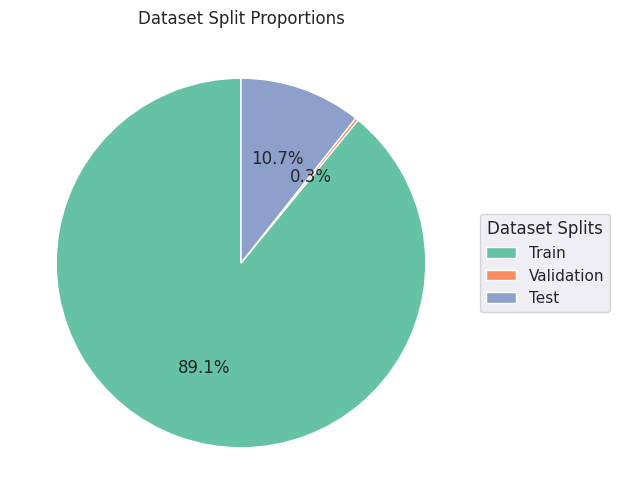

In [9]:
split_counts = {
    "Train": len(df_train),
    "Validation": len(df_val),
    "Test": len(df_test)
}


labels = list(split_counts.keys())
sizes = list(split_counts.values())


colors = plt.cm.Set2.colors[:len(labels)]


plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

plt.legend(
    wedges, labels,
    title="Dataset Splits",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title("Dataset Split Proportions")
plt.show()

## Improving Dataset Splits for Balanced Training

In [10]:
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

print("✅ Total images:", len(df_all))

✅ Total images: 5856


In [11]:
df_all["label"].value_counts()

label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64

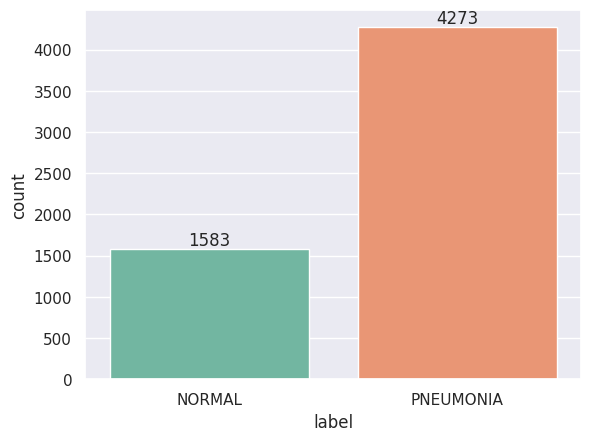

In [12]:
ax = sns.countplot(data=df_all, x='label', palette='Set2')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height,
        int(height),
        ha="center", va="bottom"
    )

plt.show()

In [13]:
df_train, df_test = train_test_split(
    df_all,
    test_size=0.2,
    stratify=df_all["label"],
    random_state=42
)


df_train, df_val = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train["label"],
    random_state=42
)

print("Train size:", len(df_train))
print("Val size:", len(df_val))
print("Test size:", len(df_test))

Train size: 3747
Val size: 937
Test size: 1172


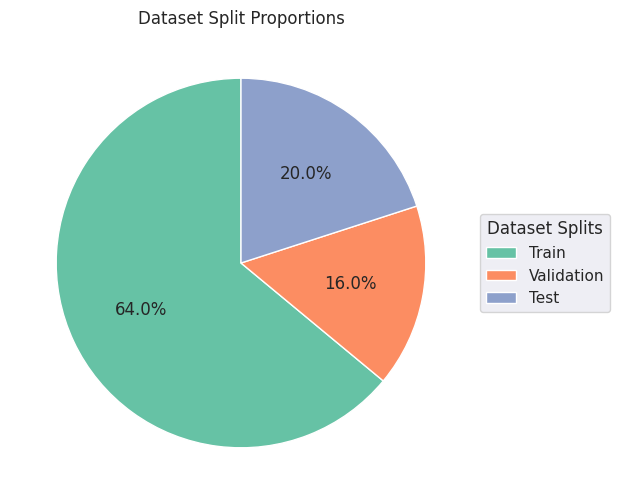

In [14]:
split_counts = {
    "Train": len(df_train),
    "Validation": len(df_val),
    "Test": len(df_test)
}


labels = list(split_counts.keys())
sizes = list(split_counts.values())


colors = plt.cm.Set2.colors[:len(labels)]


plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

plt.legend(
    wedges, labels,
    title="Dataset Splits",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title("Dataset Split Proportions")
plt.show()

In [15]:
df_splits = pd.DataFrame(list(split_counts.items()), columns=["Split", "Count"])
df_splits

Split  Count
0       Train   3747
1  Validation    937
2        Test   1172

In [16]:
df_train['label'].value_counts()

label
PNEUMONIA    2734
NORMAL       1013
Name: count, dtype: int64

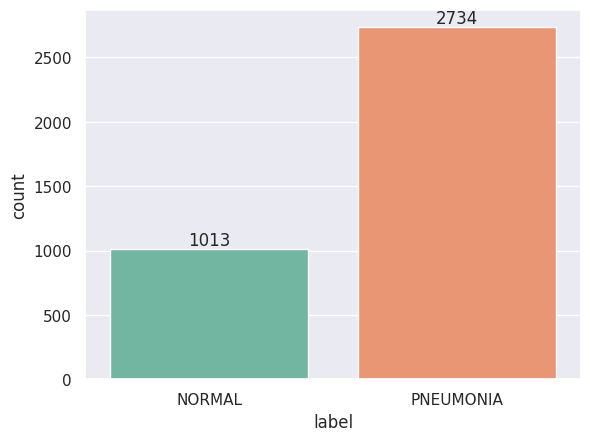

In [17]:
ax = sns.countplot(data=df_train, x='label', palette='Set2')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height,
        int(height),
        ha="center", va="bottom"
    )

plt.show()

In [18]:
df_val['label'].value_counts()

label
PNEUMONIA    684
NORMAL       253
Name: count, dtype: int64

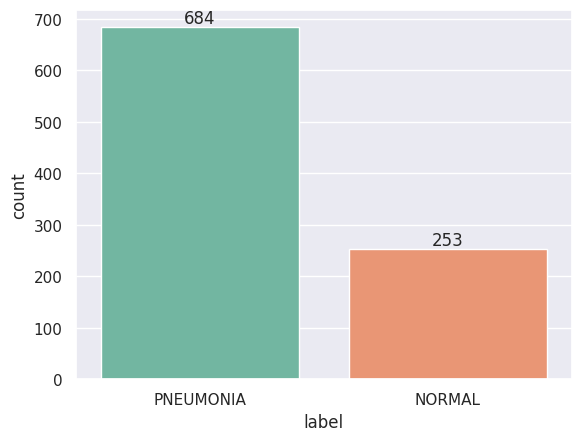

In [19]:
ax = sns.countplot(data=df_val, x='label', palette='Set2')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height,
        int(height),
        ha="center", va="bottom"
    )

plt.show()

In [20]:
df_test['label'].value_counts()

label
PNEUMONIA    855
NORMAL       317
Name: count, dtype: int64

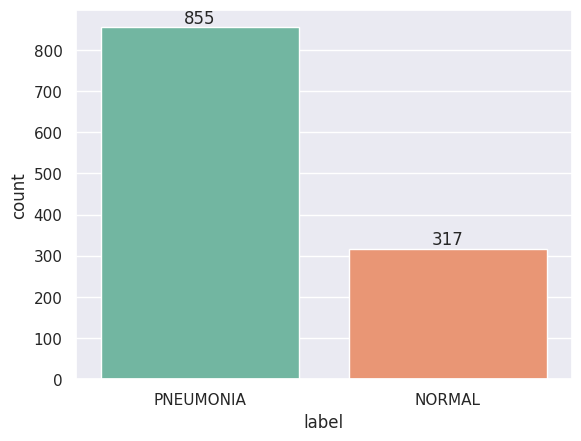

In [21]:
ax = sns.countplot(data=df_test, x='label', palette='Set2')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height,
        int(height),
        ha="center", va="bottom"
    )

plt.show()

In [22]:
def find_duplicates_in_df(df, split_name=""):
    """Find duplicate images in a DataFrame using MD5 hashes."""
    hashes = {}
    duplicates = []

    for row in df.itertuples():
        image_path = row.image_path
        label = row.label

        try:
            with open(image_path, "rb") as f:
                img_hash = hashlib.md5(f.read()).hexdigest()
                if img_hash in hashes:
                    duplicates.append((split_name, label, image_path, hashes[img_hash]))
                else:
                    hashes[img_hash] = image_path
        except Exception as e:
            print(f"⚠️ Error processing {image_path}: {e}")

    df_duplicates = pd.DataFrame(
        duplicates,
        columns=["Split", "Label", "Duplicate Path", "Original Path"]
    )

    print(f"✅ Found {len(df_duplicates)} duplicates in {split_name} set")
    return df_duplicates


def display_duplicate_images(df_duplicates):
    """Display a few duplicate/original pairs."""
    if df_duplicates.empty:
        print("No duplicates to display.")
        return

    num_samples = len(df_duplicates)
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))

    for i, row in enumerate(df_duplicates.iloc[:num_samples].itertuples()):
        try:
            original = Image.open(row._4)
            duplicate = Image.open(row._3)

            axes[i, 0].imshow(original, cmap="gray")
            axes[i, 0].set_title(f"Original ({row.Label})")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(duplicate, cmap="gray")
            axes[i, 1].set_title("Duplicate")
            axes[i, 1].axis("off")

        except Exception as e:
            print(f"⚠️ Error displaying images: {e}")

    plt.tight_layout()
    plt.show()

✅ Found 20 duplicates in Train set


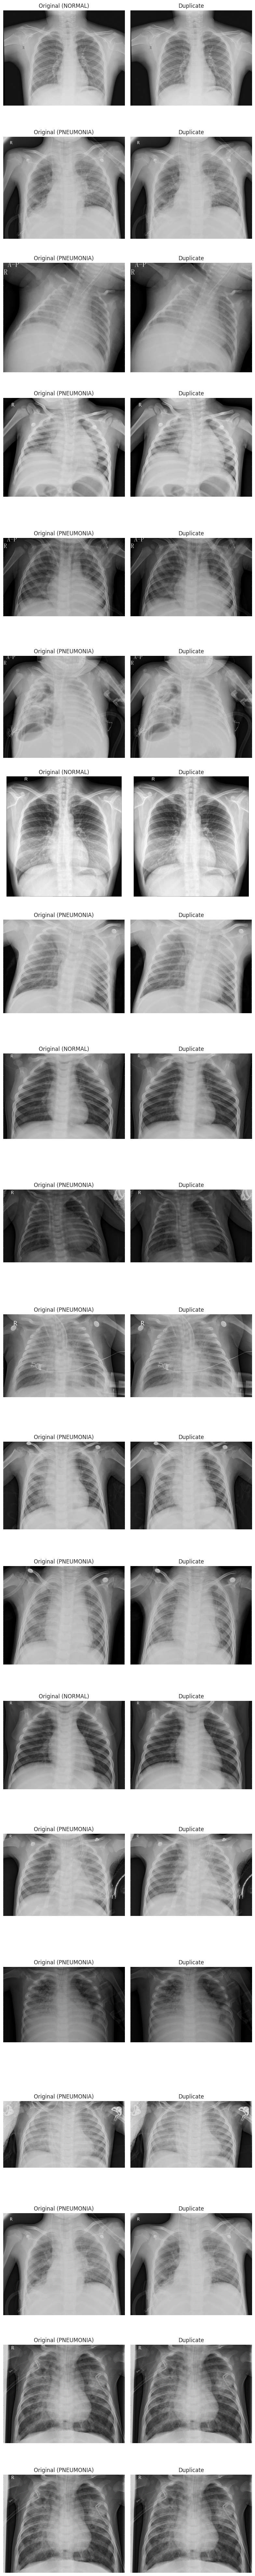

In [23]:
duplicates_train = find_duplicates_in_df(df_train, split_name="Train")
display_duplicate_images(duplicates_train)

✅ Found 1 duplicates in Validation set
⚠️ Error displaying images: too many indices for array: array is 1-dimensional, but 2 were indexed


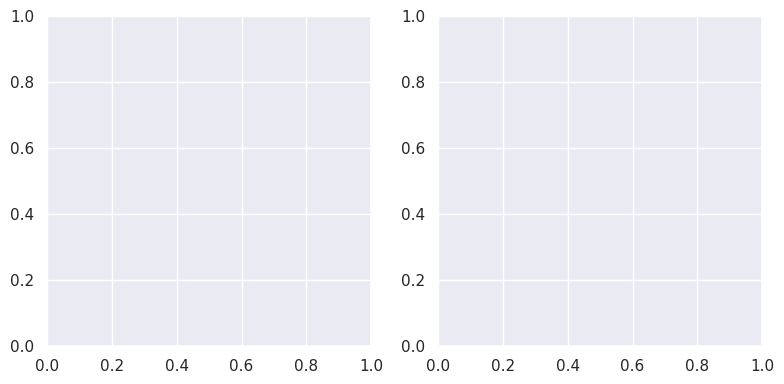

In [24]:
duplicates_val = find_duplicates_in_df(df_val, split_name="Validation")
display_duplicate_images(duplicates_val)

✅ Found 1 duplicates in Test set
⚠️ Error displaying images: too many indices for array: array is 1-dimensional, but 2 were indexed


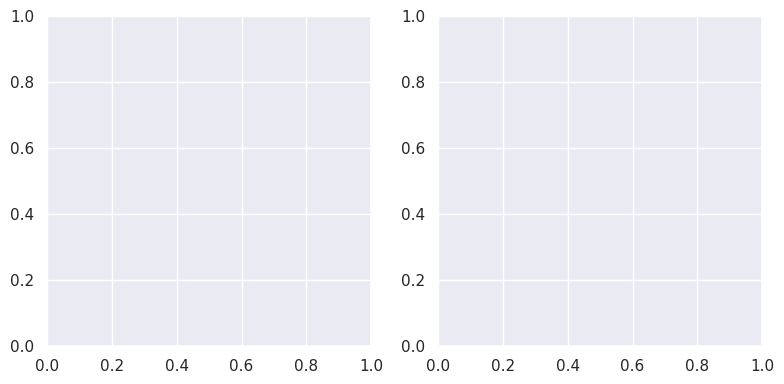

In [25]:
duplicates_test = find_duplicates_in_df(df_test, split_name="Test")
display_duplicate_images(duplicates_test)

In [26]:
def find_duplicates_in_df(df, split_name=""):
    """Find duplicate images in a DataFrame using MD5 hashes."""
    hashes = {}
    duplicates = []

    for row in df.itertuples():
        image_path = row.image_path
        label = row.label

        try:
            with open(image_path, "rb") as f:
                img_hash = hashlib.md5(f.read()).hexdigest()
                if img_hash in hashes:
                    duplicates.append((split_name, label, image_path, hashes[img_hash], img_hash))
                else:
                    hashes[img_hash] = image_path
        except Exception as e:
            print(f"⚠️ Error processing {image_path}: {e}")
    df_duplicates = pd.DataFrame(
        duplicates,
        columns=["Split", "Label", "Duplicate Path", "Original Path", "Hash"]
    )

    print(f"✅ Found {len(df_duplicates)} duplicates in {split_name} set")
    return df_duplicates

def remove_duplicates(df, split_name=""):
    """Remove duplicates from a DataFrame, keeping the first occurrence."""

    df_duplicates = find_duplicates_in_df(df, split_name)

    if df_duplicates.empty:
        print(f"✨ No duplicates found in {split_name}, nothing removed.")
        return df, df_duplicates


    print("\n📂 Duplicate files detected:")
    for row in df_duplicates.itertuples():
        print(f"❌ Duplicate: {row._3} | ✅ Original kept: {row._4}")


    df_with_hash = df.copy()
    df_with_hash["hash"] = df_with_hash["image_path"].apply(
        lambda p: hashlib.md5(open(p, "rb").read()).hexdigest()
    )
    df_cleaned = df_with_hash.drop_duplicates(subset=["hash"], keep="first").drop(columns=["hash"]).reset_index(drop=True)
    print(f"\n🧹 {len(df) - len(df_cleaned)} duplicates removed from {split_name} set.")
    print(f"📊 Final size: {len(df_cleaned)} images.")

    return df_cleaned, df_duplicates

In [27]:
df_train, dups_train = remove_duplicates(df_train, split_name="Train")

✅ Found 20 duplicates in Train set

📂 Duplicate files detected:
❌ Duplicate: /content/kaggle_PNEUMONIA/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0096-0001.jpeg | ✅ Original kept: /content/kaggle_PNEUMONIA/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0095-0001.jpeg
❌ Duplicate: /content/kaggle_PNEUMONIA/chest_xray/chest_xray/train/PNEUMONIA/person1372_bacteria_3501.jpeg | ✅ Original kept: /content/kaggle_PNEUMONIA/chest_xray/chest_xray/train/PNEUMONIA/person1372_bacteria_3503.jpeg
❌ Duplicate: /content/kaggle_PNEUMONIA/chest_xray/chest_xray/train/PNEUMONIA/person688_virus_1281.jpeg | ✅ Original kept: /content/kaggle_PNEUMONIA/chest_xray/chest_xray/train/PNEUMONIA/person688_virus_1282.jpeg
❌ Duplicate: /content/kaggle_PNEUMONIA/chest_xray/chest_xray/train/PNEUMONIA/person1349_bacteria_3436.jpeg | ✅ Original kept: /content/kaggle_PNEUMONIA/chest_xray/chest_xray/train/PNEUMONIA/person1349_bacteria_3437.jpeg
❌ Duplicate: /content/kaggle_PNEUMONIA/chest_xray/chest_xray/train/PNEUMONIA/per

In [28]:
df_train

image_path      label
0     /content/kaggle_PNEUMONIA/chest_xray/chest_xra...     NORMAL
1     /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  PNEUMONIA
2     /content/kaggle_PNEUMONIA/chest_xray/chest_xra...     NORMAL
3     /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  PNEUMONIA
4     /content/kaggle_PNEUMONIA/chest_xray/chest_xra...     NORMAL
...                                                 ...        ...
3722  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  PNEUMONIA
3723  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  PNEUMONIA
3724  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  PNEUMONIA
3725  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  PNEUMONIA
3726  /content/kaggle_PNEUMONIA/chest_xray/chest_xra...  PNEUMONIA

[3727 rows x 2 columns]

In [29]:
df_train['label'].value_counts()

label
PNEUMONIA    2718
NORMAL       1009
Name: count, dtype: int64

In [30]:
df_val, dups_test = remove_duplicates(df_val, split_name="Validation")

✅ Found 1 duplicates in Validation set

📂 Duplicate files detected:
❌ Duplicate: /content/kaggle_PNEUMONIA/chest_xray/chest_xray/train/PNEUMONIA/person1481_bacteria_3866.jpeg | ✅ Original kept: /content/kaggle_PNEUMONIA/chest_xray/chest_xray/train/PNEUMONIA/person1481_bacteria_3867.jpeg

🧹 1 duplicates removed from Validation set.
📊 Final size: 936 images.


In [31]:
df_val['label'].value_counts()

label
PNEUMONIA    683
NORMAL       253
Name: count, dtype: int64

In [32]:
df_test, dups_test = remove_duplicates(df_test, split_name="Test")

✅ Found 1 duplicates in Test set

📂 Duplicate files detected:
❌ Duplicate: /content/kaggle_PNEUMONIA/chest_xray/chest_xray/train/PNEUMONIA/person266_bacteria_1238.jpeg | ✅ Original kept: /content/kaggle_PNEUMONIA/chest_xray/chest_xray/train/PNEUMONIA/person266_bacteria_1237.jpeg

🧹 1 duplicates removed from Test set.
📊 Final size: 1171 images.


In [33]:
df_test['label'].value_counts()

label
PNEUMONIA    854
NORMAL       317
Name: count, dtype: int64

In [34]:
def check_image_sizes(df, num_samples=5):
    sizes = []
    for row in df.itertuples():
        try:
            with Image.open(row.image_path) as img:
                sizes.append(img.size)
        except Exception as e:
            print(f"⚠️ Error opening {row.image_path}: {e}")

    size_df = pd.DataFrame(sizes, columns=["Width", "Height"])
    size_counts = size_df.value_counts().reset_index(name="Count")

    print(f"\nMost common size: {tuple(size_counts.iloc[0][['Width','Height']])} "
          f"with {size_counts.iloc[0]['Count']} images")


    classes = df['label'].unique()
    fig, axes = plt.subplots(num_samples, len(classes), figsize=(len(classes) * 4, num_samples * 4))
    if len(classes) == 1:
        axes = np.expand_dims(axes, axis=1)

    for col, cls in enumerate(classes):
        class_rows = df[df['label'] == cls]
        sample_rows = random.sample(list(class_rows.itertuples()), min(num_samples, len(class_rows)))
        for row_idx, row in enumerate(sample_rows):
            ax = axes[row_idx, col] if num_samples > 1 else axes[col]
            img = Image.open(row.image_path)
            ax.imshow(img, cmap="gray")
            if row_idx == 0:
                ax.set_title(cls, fontsize=14, fontweight="bold")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

    return size_counts



Most common size: (1008, 704) with 7 images


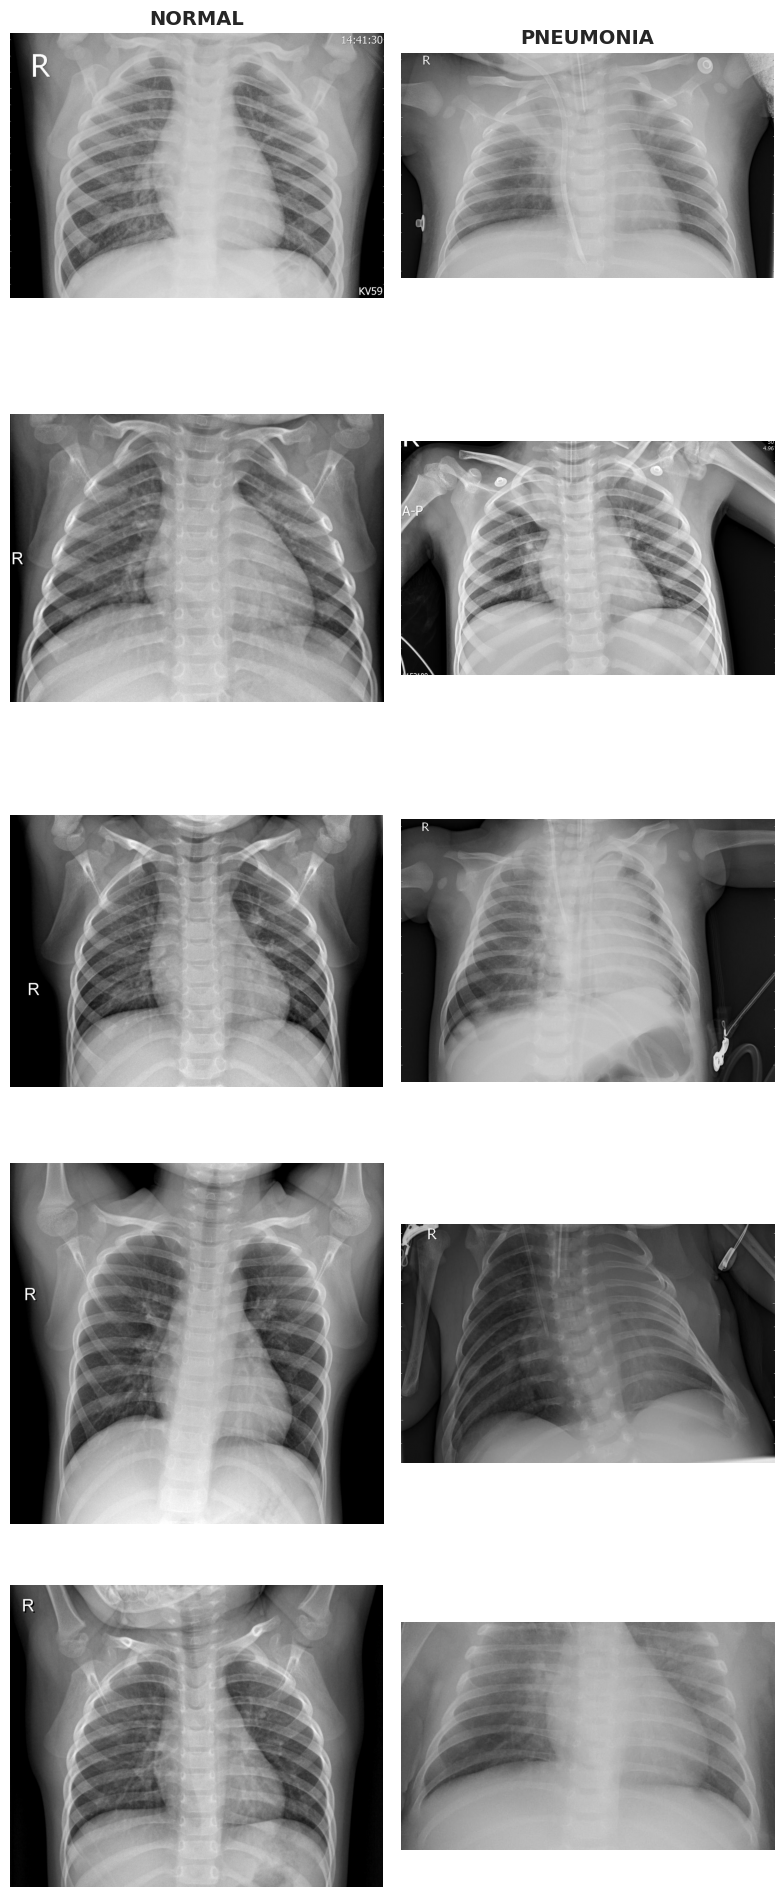

Width  Height  Count
0      1008     704      7
1      1136     680      5
2      1080     728      5
3      1216     872      5
4       992     616      4
...     ...     ...    ...
3230   1214    1106      1
3231   1216     712      1
3232   1216     728      1
3233   1216     736      1
3234   1208    1104      1

[3235 rows x 3 columns]

In [35]:
df_sizes = check_image_sizes(df_train, num_samples=5)
df_sizes

In [36]:
df_sizes.head(10)

Width  Height  Count
0   1008     704      7
1   1136     680      5
2   1080     728      5
3   1216     872      5
4    992     616      4
5   1176     784      4
6   1088     712      4
7   1008     600      4
8   1152     664      4
9   1096     784      4

In [37]:
df_sizes[df_sizes['Count'] > 1]

Width  Height  Count
0     1008     704      7
1     1136     680      5
2     1080     728      5
3     1216     872      5
4      992     616      4
..     ...     ...    ...
391   1336     824      2
392   1168     760      2
393    840     488      2
394    840     464      2
395   1168     768      2

[396 rows x 3 columns]

In [38]:
df_sizes.describe()

Width       Height        Count
count  3235.000000  3235.000000  3235.000000
mean   1357.258423  1002.074807     1.152087
std     375.046930   396.881851     0.454202
min     384.000000   127.000000     1.000000
25%    1080.000000   704.000000     1.000000
50%    1328.000000   940.000000     1.000000
75%    1596.000000  1232.000000     1.000000
max    2916.000000  2713.000000     7.000000

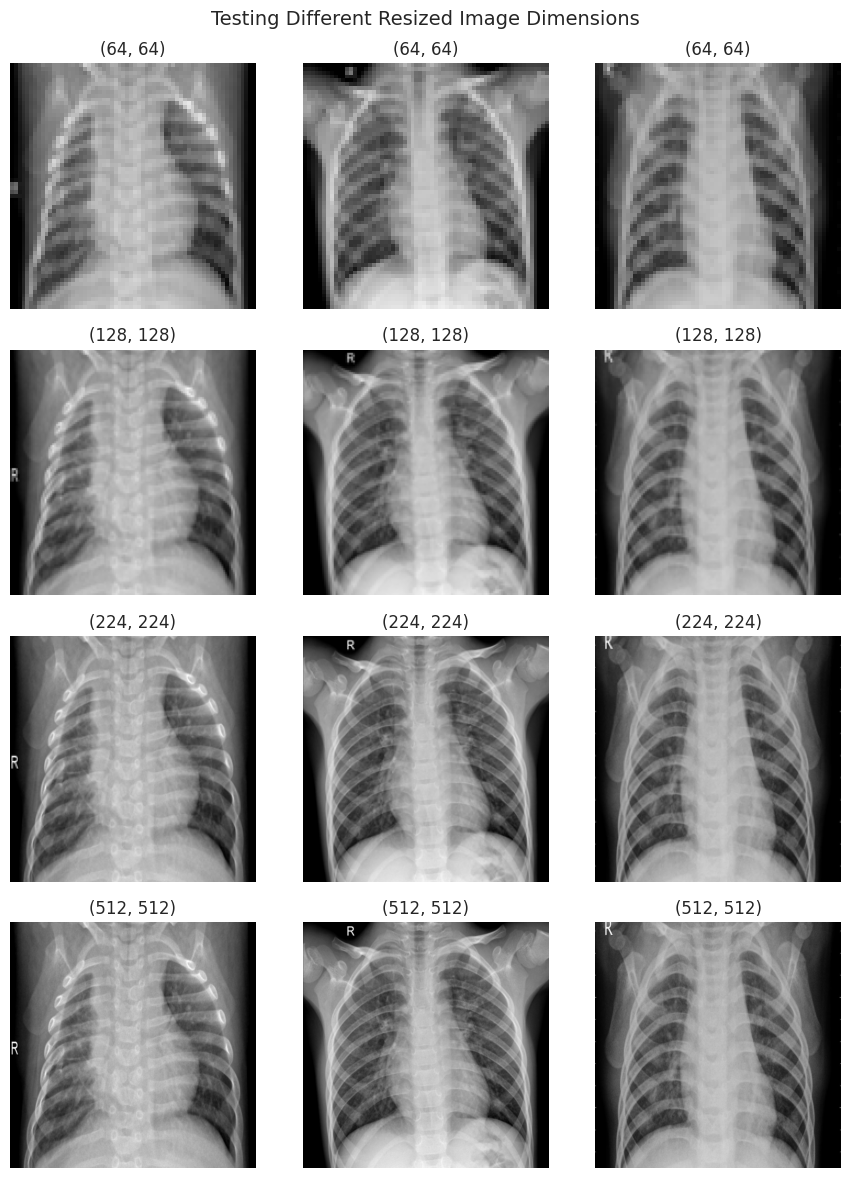

In [39]:
def test_resized_samples(df, sizes=[(64, 64), (128, 128), (224, 224), (512, 512)], images_per_size=3):
    """Show sample images from DataFrame resized to different sizes for clarity testing."""


    sample_rows = random.sample(list(df.itertuples()), min(images_per_size, len(df)))

    fig, axes = plt.subplots(len(sizes), len(sample_rows), figsize=(len(sample_rows) * 3, len(sizes) * 3))

    for i, size in enumerate(sizes):
        for j, row in enumerate(sample_rows):
            try:
                img = Image.open(row.image_path).convert("RGB")
                img_resized = img.resize(size)

                ax = axes[i, j] if len(sizes) > 1 else axes[j]
                ax.imshow(img_resized, cmap="gray")
                ax.set_title(f"{size}")
                ax.axis("off")
            except Exception as e:
                print(f"⚠️ Error opening {row.image_path}: {e}")
    plt.suptitle("Testing Different Resized Image Dimensions", fontsize=14)
    plt.tight_layout()
    plt.show()


test_resized_samples(df_train, sizes=[(64,64), (128,128), (224,224), (512,512)], images_per_size=3)

In [40]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


train_image_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=5,
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="constant",
    cval=0
)


val_test_image_generator = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="binary",
    shuffle=True,
    batch_size=BATCH_SIZE,
    seed=42
)

val_generator = val_test_image_generator.flow_from_dataframe(
    dataframe=df_val,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH_SIZE
)

test_generator = val_test_image_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col="image_path",
    y_col="label",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH_SIZE
)


Found 3727 validated image filenames belonging to 2 classes.
Found 936 validated image filenames belonging to 2 classes.
Found 1171 validated image filenames belonging to 2 classes.


In [41]:
print("Train class indices:", train_generator.class_indices)
print("Val class indices:", val_generator.class_indices)
print("Test class indices:", test_generator.class_indices)

Train class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Val class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Test class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


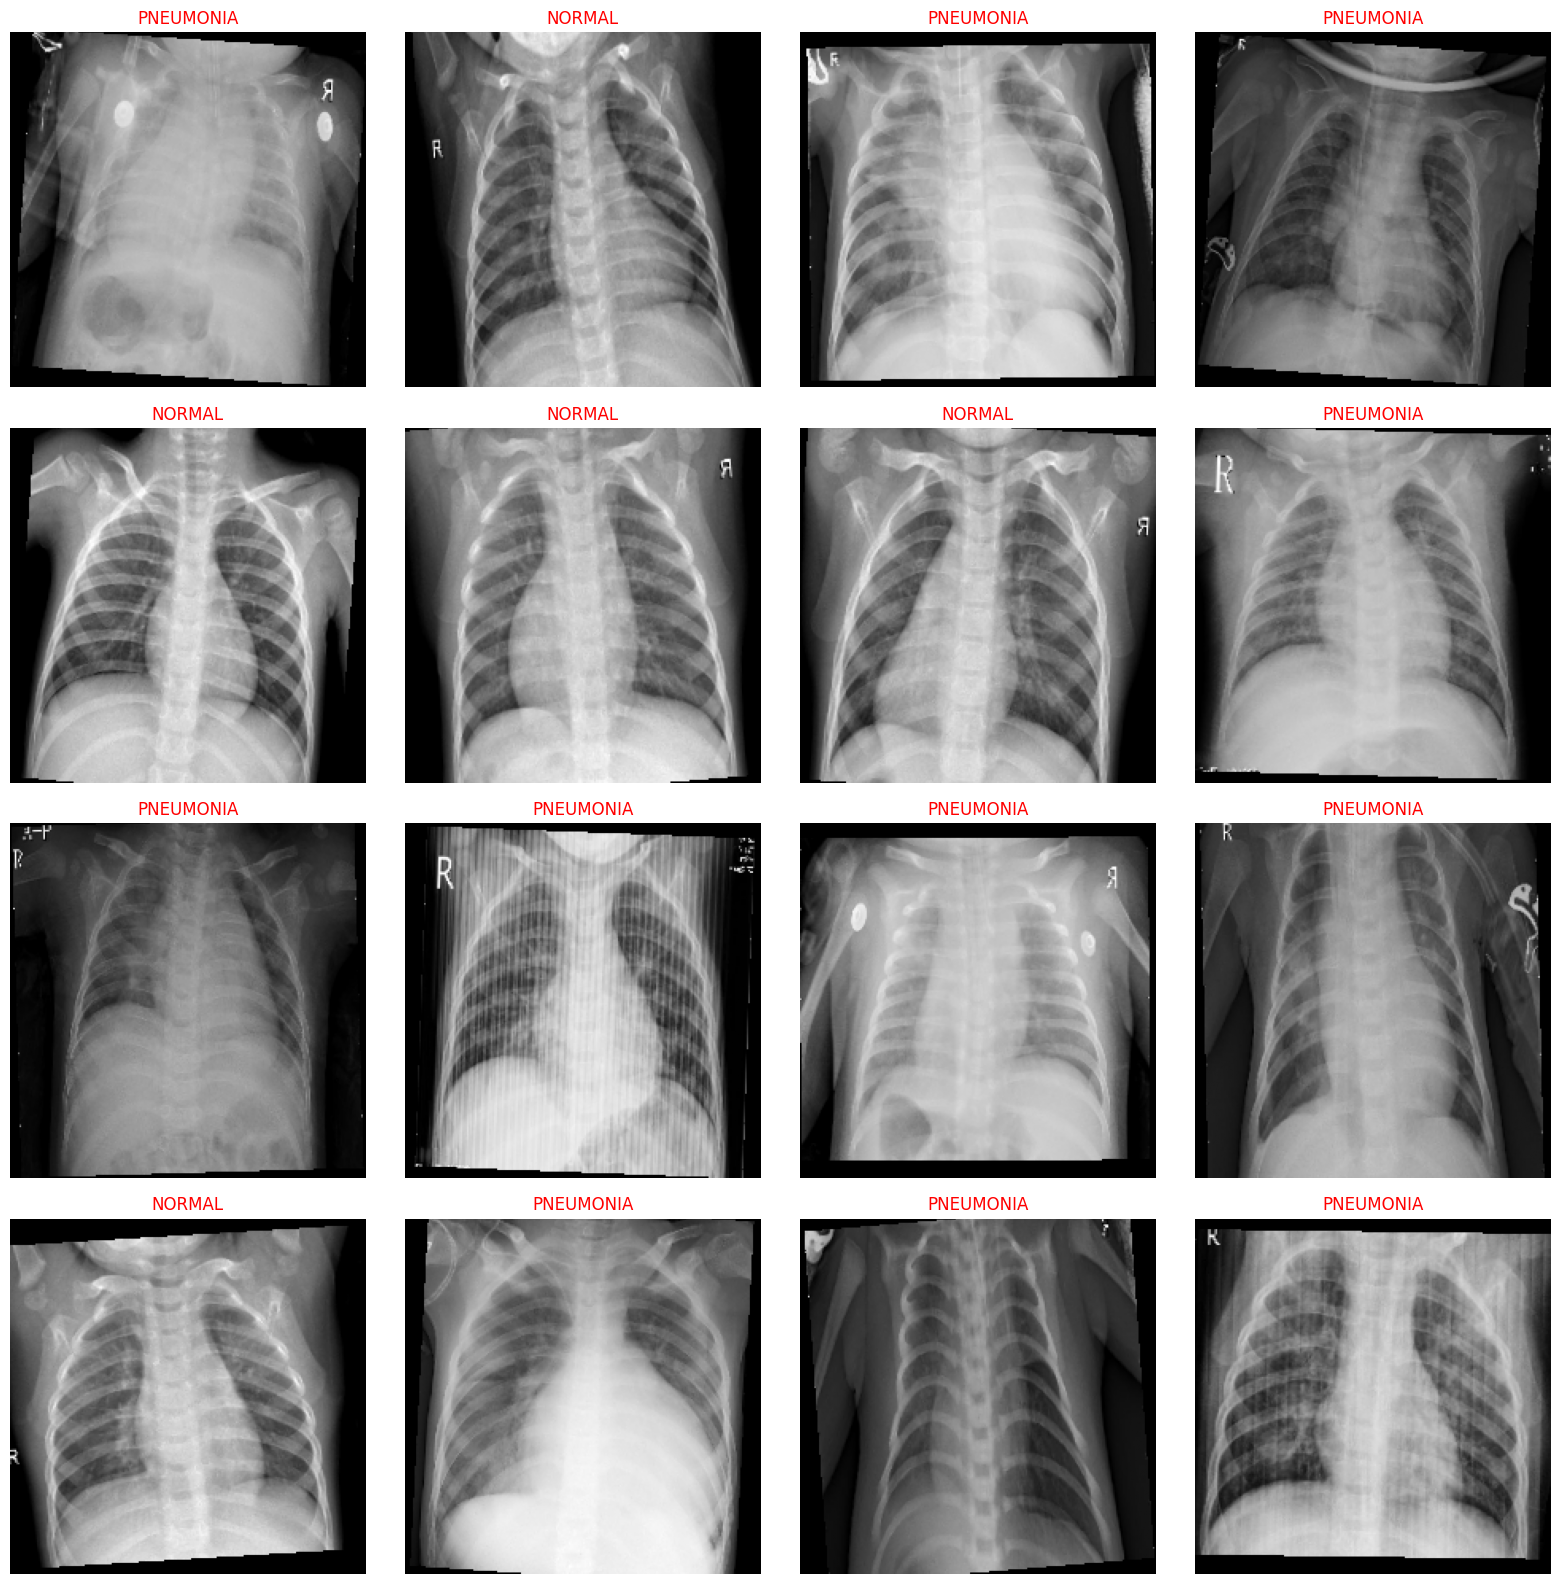

In [42]:
images, labels = next(train_generator)

class_indices = train_generator.class_indices
classes = list(class_indices.keys())

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i + 1)

    image = images[i].squeeze()
    plt.imshow(image, cmap="gray")

    index = int(labels[i])
    class_name = classes[index]

    plt.title(class_name, color="red", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()


## Convolutional Neural Network (CNN)

In [43]:
img_size = (224, 224)
channels = 1
img_shape = (img_size[0], img_size[1], channels)


model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),


    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(1, activation='sigmoid')
])

model.compile(Adamax(learning_rate= 0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,152,833 (80.69 MB)

 Trainable params: 21,152,833 (80.69 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
early_stopping = callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

In [45]:
epochs = 30

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


Epoch 1/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.6975 - loss: 0.6244
Epoch 1: val_accuracy improved from -inf to 0.72970, saving model to best_model.h5


117/117 ━━━━━━━━━━━━━━━━━━━━ 142s 856ms/step - accuracy: 0.6977 - loss: 0.6242 - val_accuracy: 0.7297 - val_loss: 0.5947
Epoch 2/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.7386 - loss: 0.5810
Epoch 2: val_accuracy did not improve from 0.72970
117/117 ━━━━━━━━━━━━━━━━━━━━ 59s 506ms/step - accuracy: 0.7386 - loss: 0.5810 - val_accuracy: 0.7297 - val_loss: 0.5836
Epoch 3/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.7373 - loss: 0.5769
Epoch 3: val_accuracy did not improve from 0.72970
117/117 ━━━━━━━━━━━━━━━━━━━━ 60s 509ms/step - accuracy: 0.7372 - loss: 0.5770 - val_accuracy: 0.7297 - val_loss: 0.5495
Epoch 4/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.7238 - loss: 0.5575
Epoch 4: val_accuracy improved from 0.72970 to 0.75641, saving model to best_model.h5


117/117 ━━━━━━━━━━━━━━━━━━━━ 60s 511ms/step - accuracy: 0.7240 - loss: 0.5573 - val_accuracy: 0.7564 - val_loss: 0.5158
Epoch 5/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.7684 - loss: 0.5000
Epoch 5: val_accuracy improved from 0.75641 to 0.80235, saving model to best_model.h5


117/117 ━━━━━━━━━━━━━━━━━━━━ 60s 511ms/step - accuracy: 0.7685 - loss: 0.4999 - val_accuracy: 0.8024 - val_loss: 0.4178
Epoch 6/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7978 - loss: 0.4451
Epoch 6: val_accuracy improved from 0.80235 to 0.88675, saving model to best_model.h5


117/117 ━━━━━━━━━━━━━━━━━━━━ 64s 544ms/step - accuracy: 0.7980 - loss: 0.4447 - val_accuracy: 0.8868 - val_loss: 0.2979
Epoch 7/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8918 - loss: 0.2568
Epoch 7: val_accuracy improved from 0.88675 to 0.90171, saving model to best_model.h5


117/117 ━━━━━━━━━━━━━━━━━━━━ 63s 539ms/step - accuracy: 0.8918 - loss: 0.2567 - val_accuracy: 0.9017 - val_loss: 0.2249
Epoch 8/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9177 - loss: 0.2036
Epoch 8: val_accuracy improved from 0.90171 to 0.90705, saving model to best_model.h5


117/117 ━━━━━━━━━━━━━━━━━━━━ 68s 576ms/step - accuracy: 0.9177 - loss: 0.2037 - val_accuracy: 0.9071 - val_loss: 0.2249
Epoch 9/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9306 - loss: 0.1875
Epoch 9: val_accuracy improved from 0.90705 to 0.91346, saving model to best_model.h5


117/117 ━━━━━━━━━━━━━━━━━━━━ 66s 562ms/step - accuracy: 0.9306 - loss: 0.1875 - val_accuracy: 0.9135 - val_loss: 0.2067
Epoch 10/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.9326 - loss: 0.1826
Epoch 10: val_accuracy improved from 0.91346 to 0.91880, saving model to best_model.h5


117/117 ━━━━━━━━━━━━━━━━━━━━ 67s 571ms/step - accuracy: 0.9325 - loss: 0.1827 - val_accuracy: 0.9188 - val_loss: 0.2071
Epoch 11/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9281 - loss: 0.1833
Epoch 11: val_accuracy did not improve from 0.91880
117/117 ━━━━━━━━━━━━━━━━━━━━ 64s 542ms/step - accuracy: 0.9281 - loss: 0.1833 - val_accuracy: 0.9081 - val_loss: 0.2314
Epoch 12/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9366 - loss: 0.1661
Epoch 12: val_accuracy did not improve from 0.91880
117/117 ━━━━━━━━━━━━━━━━━━━━ 60s 509ms/step - accuracy: 0.9365 - loss: 0.1661 - val_accuracy: 0.8953 - val_loss: 0.2490
Epoch 13/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9463 - loss: 0.1510
Epoch 13: val_accuracy did not improve from 0.91880
117/117 ━━━━━━━━━━━━━━━━━━━━ 59s 505ms/step - accuracy: 0.9463 - loss: 0.1510 - val_accuracy: 0.8996 - val_loss: 0.2379
Epoch 14/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9393 - loss: 0.1564
Epoch 14

117/117 ━━━━━━━━━━━━━━━━━━━━ 67s 569ms/step - accuracy: 0.9393 - loss: 0.1564 - val_accuracy: 0.9327 - val_loss: 0.1584
Epoch 15/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9504 - loss: 0.1342
Epoch 15: val_accuracy improved from 0.93269 to 0.94231, saving model to best_model.h5


117/117 ━━━━━━━━━━━━━━━━━━━━ 64s 543ms/step - accuracy: 0.9503 - loss: 0.1343 - val_accuracy: 0.9423 - val_loss: 0.1515
Epoch 16/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9351 - loss: 0.1786
Epoch 16: val_accuracy did not improve from 0.94231
117/117 ━━━━━━━━━━━━━━━━━━━━ 60s 511ms/step - accuracy: 0.9352 - loss: 0.1784 - val_accuracy: 0.9209 - val_loss: 0.1914
Epoch 17/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9422 - loss: 0.1423
Epoch 17: val_accuracy improved from 0.94231 to 0.94551, saving model to best_model.h5


117/117 ━━━━━━━━━━━━━━━━━━━━ 67s 567ms/step - accuracy: 0.9422 - loss: 0.1424 - val_accuracy: 0.9455 - val_loss: 0.1525
Epoch 18/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9507 - loss: 0.1318
Epoch 18: val_accuracy did not improve from 0.94551
117/117 ━━━━━━━━━━━━━━━━━━━━ 61s 514ms/step - accuracy: 0.9507 - loss: 0.1318 - val_accuracy: 0.9402 - val_loss: 0.1629
Epoch 19/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9524 - loss: 0.1346
Epoch 19: val_accuracy improved from 0.94551 to 0.95085, saving model to best_model.h5


117/117 ━━━━━━━━━━━━━━━━━━━━ 105s 897ms/step - accuracy: 0.9524 - loss: 0.1346 - val_accuracy: 0.9509 - val_loss: 0.1274
Epoch 20/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9469 - loss: 0.1305
Epoch 20: val_accuracy improved from 0.95085 to 0.95513, saving model to best_model.h5


117/117 ━━━━━━━━━━━━━━━━━━━━ 66s 564ms/step - accuracy: 0.9469 - loss: 0.1304 - val_accuracy: 0.9551 - val_loss: 0.1276
Epoch 21/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9557 - loss: 0.1165
Epoch 21: val_accuracy did not improve from 0.95513
117/117 ━━━━━━━━━━━━━━━━━━━━ 60s 512ms/step - accuracy: 0.9557 - loss: 0.1165 - val_accuracy: 0.9113 - val_loss: 0.2581
Epoch 22/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9539 - loss: 0.1168
Epoch 22: val_accuracy did not improve from 0.95513
117/117 ━━━━━━━━━━━━━━━━━━━━ 60s 511ms/step - accuracy: 0.9539 - loss: 0.1169 - val_accuracy: 0.9306 - val_loss: 0.1724
Epoch 23/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9537 - loss: 0.1204
Epoch 23: val_accuracy did not improve from 0.95513
117/117 ━━━━━━━━━━━━━━━━━━━━ 60s 510ms/step - accuracy: 0.9537 - loss: 0.1204 - val_accuracy: 0.9509 - val_loss: 0.1341
Epoch 24/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9529 - loss: 0.1210
Epoch 24

117/117 ━━━━━━━━━━━━━━━━━━━━ 72s 610ms/step - accuracy: 0.9529 - loss: 0.1211 - val_accuracy: 0.9562 - val_loss: 0.1212
Epoch 25/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9613 - loss: 0.1103
Epoch 25: val_accuracy did not improve from 0.95620
117/117 ━━━━━━━━━━━━━━━━━━━━ 60s 509ms/step - accuracy: 0.9613 - loss: 0.1104 - val_accuracy: 0.9466 - val_loss: 0.1424
Epoch 26/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9579 - loss: 0.1228
Epoch 26: val_accuracy did not improve from 0.95620
117/117 ━━━━━━━━━━━━━━━━━━━━ 60s 509ms/step - accuracy: 0.9579 - loss: 0.1227 - val_accuracy: 0.9541 - val_loss: 0.1285
Epoch 27/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.9640 - loss: 0.0935
Epoch 27: val_accuracy did not improve from 0.95620
117/117 ━━━━━━━━━━━━━━━━━━━━ 60s 510ms/step - accuracy: 0.9640 - loss: 0.0935 - val_accuracy: 0.9498 - val_loss: 0.1240
Epoch 28/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9600 - loss: 0.1014
Epoch 28

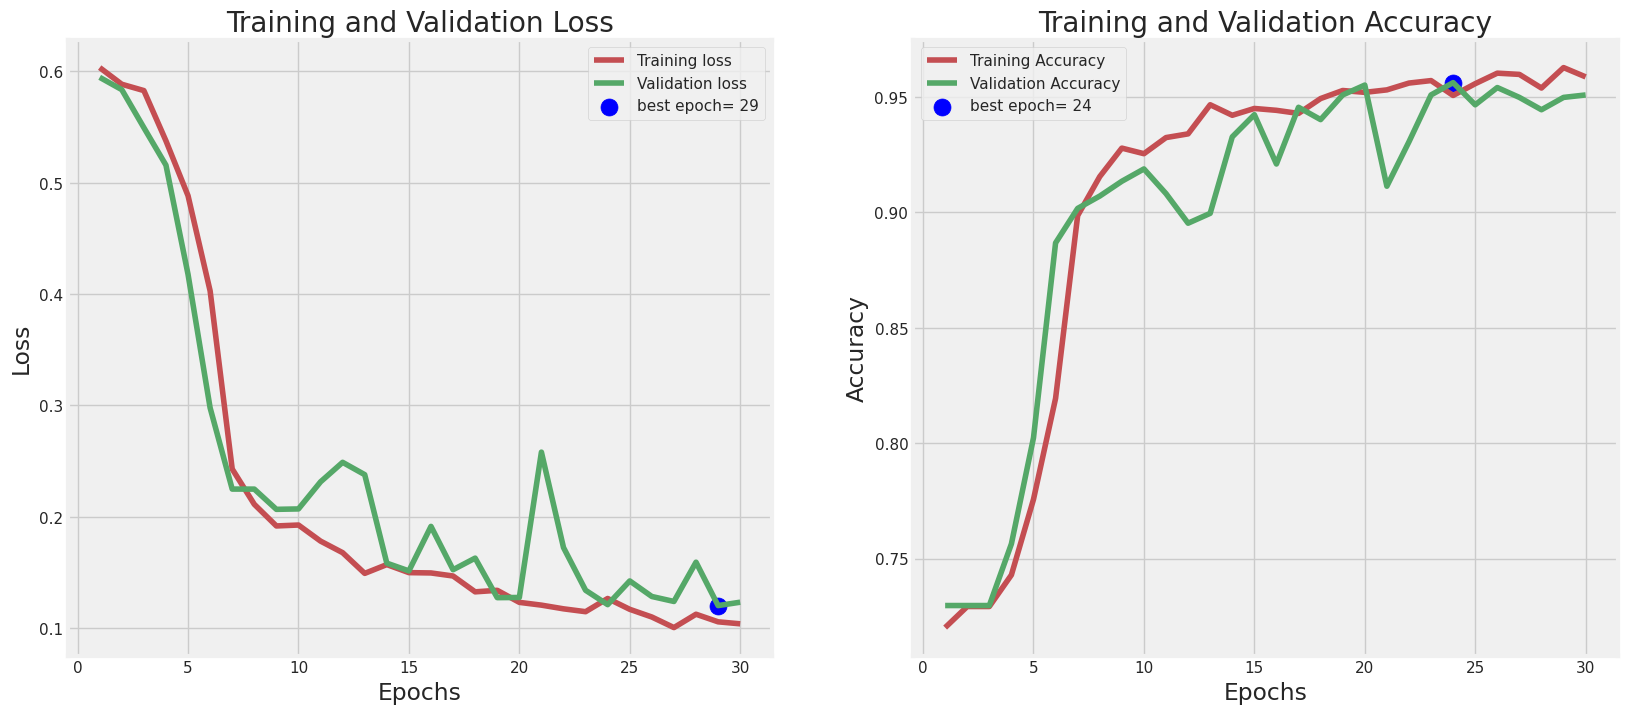

In [46]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [47]:
train_score = model.evaluate(train_generator, verbose= 1)
valid_score = model.evaluate(val_generator, verbose= 1)
test_score = model.evaluate(test_generator, verbose= 1)

print("\nTrain Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


117/117 ━━━━━━━━━━━━━━━━━━━━ 47s 397ms/step - accuracy: 0.9588 - loss: 0.1190
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.9576 - loss: 0.1181
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 432ms/step - accuracy: 0.9501 - loss: 0.1429

Train Loss:  0.11815077811479568
Train Accuracy:  0.9584115743637085
--------------------
Validation Loss:  0.12115383893251419
Validation Accuracy:  0.9561966061592102
--------------------
Test Loss:  0.13761919736862183
Test Accuracy:  0.9479077458381653


In [48]:
y_pred_prob = model.predict(test_generator)
y_pred_prob


37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step


array([[0.5082015],
       [0.9960317],
       [0.6294337],
       ...,
       [0.9193701],
       [0.8250756],
       [0.9856209]], dtype=float32)

In [49]:
y_pred = (y_pred_prob >= 0.5).astype(int).ravel()
y_pred


array([1, 1, 1, ..., 1, 1, 1])

In [50]:
y_true = test_generator.classes
y_true

[1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,


In [51]:
CM = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", CM)

Confusion Matrix:
 [[286  31]
 [ 30 824]]


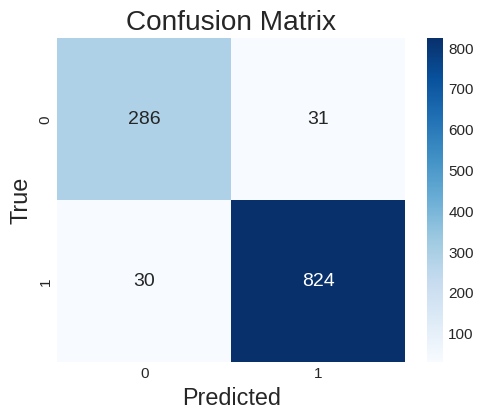

In [53]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(5,4))
sns.heatmap(CM, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix")
plt.show()

In [54]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.91      0.90      0.90       317
   PNEUMONIA       0.96      0.96      0.96       854

    accuracy                           0.95      1171
   macro avg       0.93      0.93      0.93      1171
weighted avg       0.95      0.95      0.95      1171



In [55]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.9479
Precision: 0.9637
Recall:    0.9649
F1 Score:  0.9643


In [56]:
images, labels = next(test_generator)

image = images[0]
true_label = labels[0]

pred = model.predict(np.expand_dims(image, axis=0))

prob = pred[0][0]
predicted_class = 1 if prob >= 0.5 else 0

print("Probability:", prob)
print("Predicted Class:", predicted_class)
print("True Label:", true_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Probability: 0.50820136
Predicted Class: 1
True Label: 1.0
